# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [ ]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [15]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [16]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Create training set and define training dataloader
dataset_train = torchvision.datasets.MNIST('/root/data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=250, shuffle=True)

# Create test set and define test dataloader
dataset_test = torchvision.datasets.MNIST('/root/data', train=False, download=True, transform=transform)


# Define the size of the validation set
val_size = 5000  # Number of samples for the validation set
test_size = len(dataset_test) - val_size  # Remaining samples for the reduced test set


# Split the test dataset
val_set, test_set = random_split(dataset_test, [val_size, test_size])

# Create DataLoader objects for validation and test sets
test_loader = DataLoader(test_set, batch_size=250, shuffle=True)
val_loader = DataLoader(val_set, batch_size=250, shuffle=True)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

PyTorch model expect input data to be in the form of tensors and ToTensor() ensures that the data is in tensor format. Normalize() adjusts the pixel values to be centred around zero and that can help with model convergence during training.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [72]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


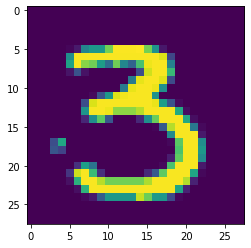

6


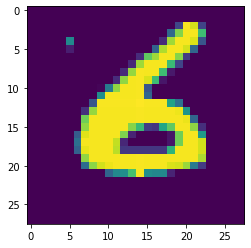

5


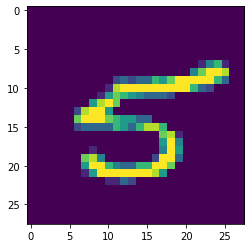

8


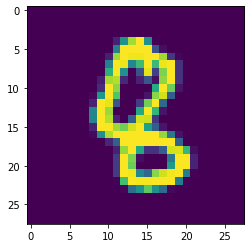

3


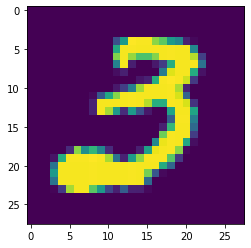

In [73]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
# Instantiate the model
net = Net()
net.to(device)

# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [37]:
def train_model(net, train_loader, val_loader, optimizer, criterion, num_epochs=10):
   # Establish a list for our history
    train_loss_history = list()
    val_loss_history = list()

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        for i, data in enumerate(train_loader):
            # data is a list of [inputs, labels]
            inputs, labels = data

            # Pass to GPU if available.
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).float().mean().item()
            train_loss += loss.item()
        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))


        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).float().mean().item()
            val_loss += loss.item()
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
        val_loss_history.append(val_loss/len(val_loader))

    return train_loss_history, val_loss_history

In [14]:
# Start training
train_loss_history, val_loss_history = train_model(net, train_loader, val_loader, optimizer, criterion, num_epochs=10)

Epoch 1 training accuracy: 0.81% training loss: 0.66687
Epoch 1 validation accuracy: 0.90% validation loss  0.42091
Epoch 2 training accuracy: 0.91% training loss: 0.30591
Epoch 2 validation accuracy: 0.93% validation loss  0.28179
Epoch 3 training accuracy: 0.93% training loss: 0.24542
Epoch 3 validation accuracy: 0.94% validation loss  0.19495
Epoch 4 training accuracy: 0.94% training loss: 0.20030
Epoch 4 validation accuracy: 0.95% validation loss  0.15476
Epoch 5 training accuracy: 0.95% training loss: 0.16727
Epoch 5 validation accuracy: 0.95% validation loss  0.17526
Epoch 6 training accuracy: 0.96% training loss: 0.14509
Epoch 6 validation accuracy: 0.96% validation loss  0.16291
Epoch 7 training accuracy: 0.96% training loss: 0.12767
Epoch 7 validation accuracy: 0.96% validation loss  0.10242
Epoch 8 training accuracy: 0.97% training loss: 0.11534
Epoch 8 validation accuracy: 0.96% validation loss  0.12986
Epoch 9 training accuracy: 0.97% training loss: 0.10601
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

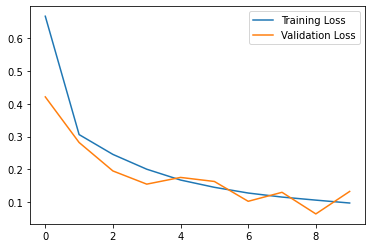

In [15]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
import torch

def compute_accuracy(model, data_loader, device):

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy


test_accuracy = compute_accuracy(net, test_loader, device)
print(f'Accuracy on the test set: {test_accuracy:.2f}%')


Accuracy on the test set: 96.48%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [51]:
# Instantiate the model
net = Net()
net.to(device)

# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.005)

# Choose a loss function
criterion = nn.CrossEntropyLoss()


In [52]:
train_loss_history, val_loss_history = train_model(net, train_loader, val_loader, optimizer, criterion, num_epochs=10)

Epoch 1 training accuracy: 0.86% training loss: 0.44747
Epoch 1 validation accuracy: 0.93% validation loss: 0.22839
Epoch 2 training accuracy: 0.94% training loss: 0.19987
Epoch 2 validation accuracy: 0.95% validation loss: 0.15539
Epoch 3 training accuracy: 0.96% training loss: 0.14349
Epoch 3 validation accuracy: 0.96% validation loss: 0.12301
Epoch 4 training accuracy: 0.96% training loss: 0.12701
Epoch 4 validation accuracy: 0.96% validation loss: 0.12203
Epoch 5 training accuracy: 0.97% training loss: 0.11163
Epoch 5 validation accuracy: 0.96% validation loss: 0.12381
Epoch 6 training accuracy: 0.97% training loss: 0.09867
Epoch 6 validation accuracy: 0.96% validation loss: 0.12549
Epoch 7 training accuracy: 0.97% training loss: 0.09017
Epoch 7 validation accuracy: 0.97% validation loss: 0.11251
Epoch 8 training accuracy: 0.97% training loss: 0.08480
Epoch 8 validation accuracy: 0.96% validation loss: 0.13641
Epoch 9 training accuracy: 0.97% training loss: 0.08213
Epoch 9 validati

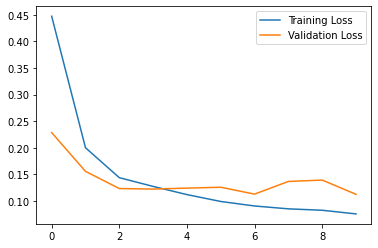

In [53]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [54]:
test_accuracy = compute_accuracy(net, test_loader, device)
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

Accuracy on the test set: 97.06%


## Saving your model
Using `torch.save`, save your model for future loading.

In [55]:
torch.save(net.state_dict(), 'model_state.pth')